In [113]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.util import view_as_blocks



In [3]:
video_path = '../video_samples/news.mpg'


In [317]:
# Create a VideoCapture object and read from input file
# If the input is the camera, pass 0 instead of the video file name
cap = cv2.VideoCapture(video_path)
# Read until video is completed
count = 0
while(cap.isOpened()):
  # Capture frame-by-frame
  ret, frame = cap.read()
  if ret == True:
    count+=1
    # Display the resulting frame
    cv2.imshow('Frame',frame)

    # Press Q on keyboard to  exit
    if cv2.waitKey(25) & 0xFF == ord('q'):
      break
    
  # Break the loop
  else: 
    break

# When everything done, release the video capture object
cap.release()

# Closes all the frames
cv2.destroyAllWindows()

[mpeg1video @ 0x559698235d80] ac-tex damaged at 0 10
[mpeg1video @ 0x559698235d80] Warning MVs not available


In [199]:
cap = cv2.VideoCapture(video_path)
frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frames = [np.zeros(shape = (frameHeight, frameWidth))]
original_frames = []
# Read until video is completed
while(cap.isOpened()):
  # Capture frame-by-frame
  ret, frame = cap.read() # first frame
  if ret == True:
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frames.append(frame)
  # Break the loop
  else: 
    break

# When everything done, release the video capture object
cap.release()

#



[mpeg1video @ 0x559673d1c6c0] ac-tex damaged at 0 10
[mpeg1video @ 0x559673d1c6c0] Warning MVs not available


## Pixel Difference

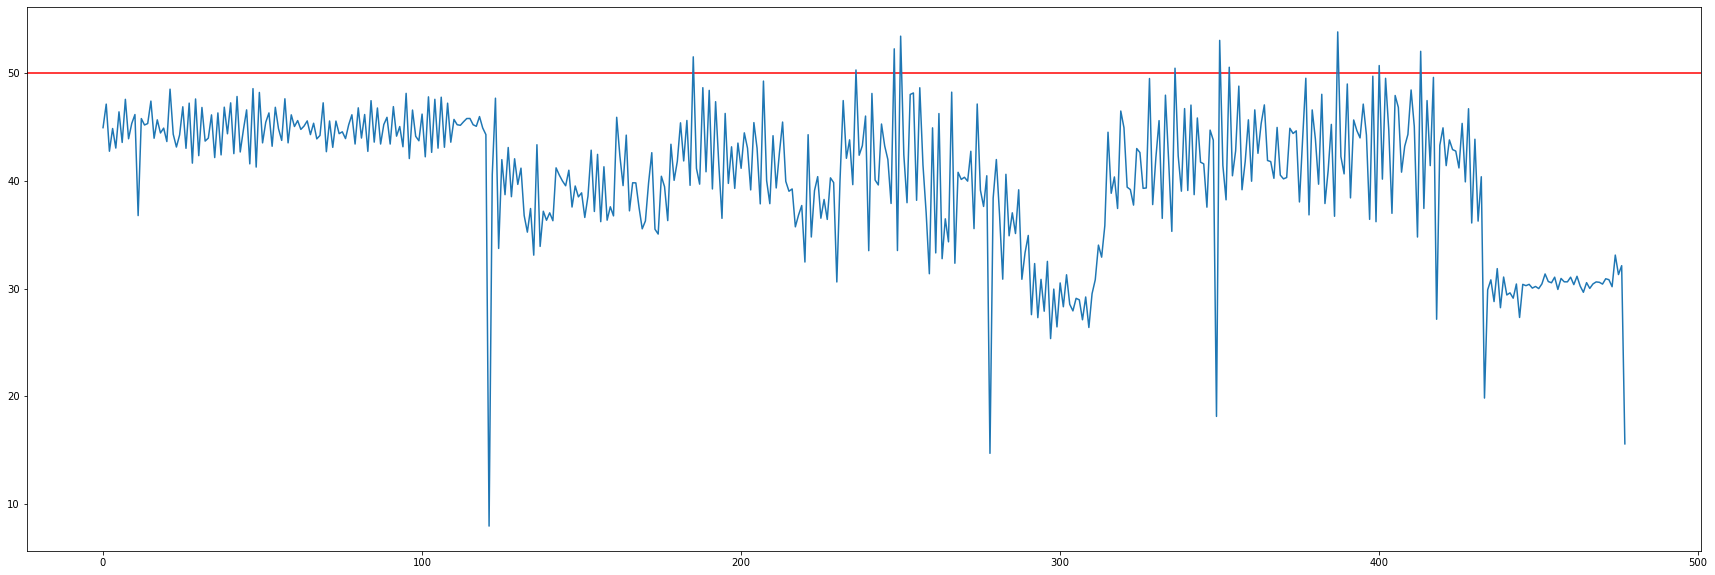

In [94]:
np_video = np.array(frames, dtype = np.dtype('uint8'))
diffs = np.abs(np.diff(np_video, 1, axis = 0))
img_dim = np_video.shape[1] * np_video.shape[2]
count = np.count_nonzero(diffs > 220, axis = (1,2))/img_dim*100
np_video = np.delete(np_video, 0, axis = 0)
fig, ax = plt.subplots(figsize = (30,10))
ax.axhline(y = 50, color = 'r', linestyle = '-')
ax.plot(count[1:])

In [96]:
selected_frames = ((np.argwhere(count > 50)).ravel())
new_frames = np_video[selected_frames]
print('Quantidade de frames original: ', len(diffs))
print('Quantidade de frames após SBD: ', len(new_frames))

Quantidade de frames original:  479
Quantidade de frames após SBD:  10


In [81]:
selected_frames

array([162, 186, 189, 208, 233, 237, 242, 249, 251, 254, 257, 267, 275,
       329, 337, 342, 351, 354, 357, 378, 388, 391, 399, 401, 403, 406,
       411, 414, 418])

In [88]:
(np.abs(np_video[400] - np_video[401]))

array([[254,  10,  28, ..., 255,   0,   0],
       [250,   6,  26, ...,   0, 255, 253],
       [254,  10,  26, ...,   1,   0, 255],
       ...,
       [ 26,  17,   8, ...,   8,   2,   0],
       [255, 255,   0, ..., 255, 255, 255],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

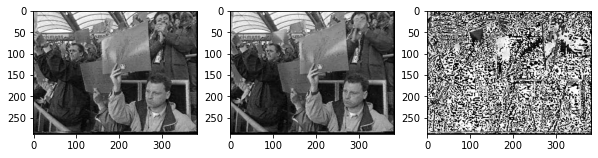

In [86]:
fig, ax = plt.subplots(figsize = (10,10),nrows = 1, ncols = 3)
ax[0].imshow(np_video[400], cmap = 'gray')
ax[1].imshow(np_video[401], cmap = 'gray')
ax[2].imshow(diffs[401], cmap = 'gray')


In [42]:
len(np.abs(np_video[161] - np_video[160]) > 200)*100/img_dim

0.2604166666666667

In [28]:
img_dim

110592

In [97]:
for frame in new_frames:
    cv2.imshow('Frame', frame)

    
    # Press Q on keyboard to  exit
    if cv2.waitKey(200) & 0xFF == ord('q'):
      break

cv2.destroyAllWindows()


In [108]:
frameHeight/8

36.0

## Block Difference

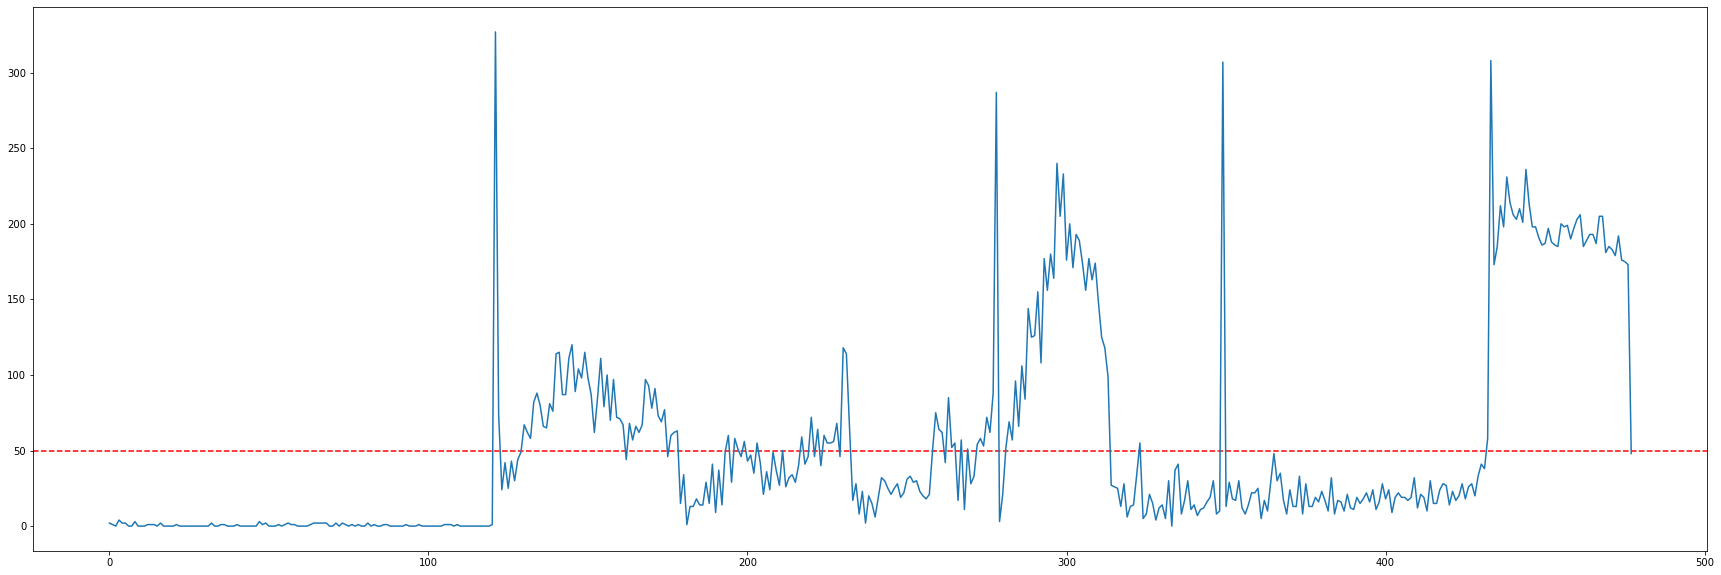

In [224]:
np_video = np.array(frames, dtype = np.dtype('uint8'))
frame_blocks = view_as_blocks(np_video,(1, 16, 16)).squeeze()
block_rmse = np.sqrt((np.diff(np.abs(frame_blocks), axis = 0)**2).mean(axis = (3,4)))
block_percentage_greater_than_T1 = np.count_nonzero(block_rmse > 10, axis = (1,2))
np_video = np.delete(np_video, 0, axis = 0)

fig, ax = plt.subplots(figsize = (30,10))
ax.axhline(y = 50, color = 'r', linestyle = '--')
ax.plot(block_percentage_greater_than_T1[1:])

In [217]:
block_selected_frames = ((np.argwhere(block_percentage_greater_than_T1 >= 50)).ravel())
block_new_frames = np_video[block_selected_frames]
print('Quantidade de frames original: ', len(diffs))
print('Quantidade de frames após SBD: ', len(block_new_frames))

Quantidade de frames original:  479
Quantidade de frames após SBD:  11


In [218]:
block_selected_frames

array([  0, 122, 150, 151, 155, 231, 232, 279, 300, 350, 434])

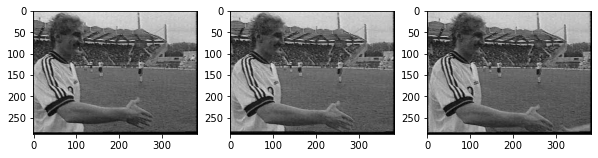

In [209]:
fig, ax = plt.subplots(figsize = (10,10),nrows = 1, ncols = 3)
ax[0].imshow(np_video[135], cmap = 'gray')
ax[1].imshow(np_video[136], cmap = 'gray')
ax[2].imshow(np_video[137], cmap = 'gray')


In [198]:
for frame in block_new_frames:
    cv2.imshow('Frame', frame)

    
    # Press Q on keyboard to  exit
    if cv2.waitKey(200) & 0xFF == ord('q'):
      break

cv2.destroyAllWindows()


## Histogram difference

In [318]:
np_video = np.array(frames, dtype = np.dtype('uint8'))
hist_video = np_video.reshape(np_video.shape[0], -1)
histograms = np.apply_along_axis(lambda x: np.histogram(x, np.arange(256))[0], 1, hist_video)
np_video = np.delete(np_video, 0, axis = 0)


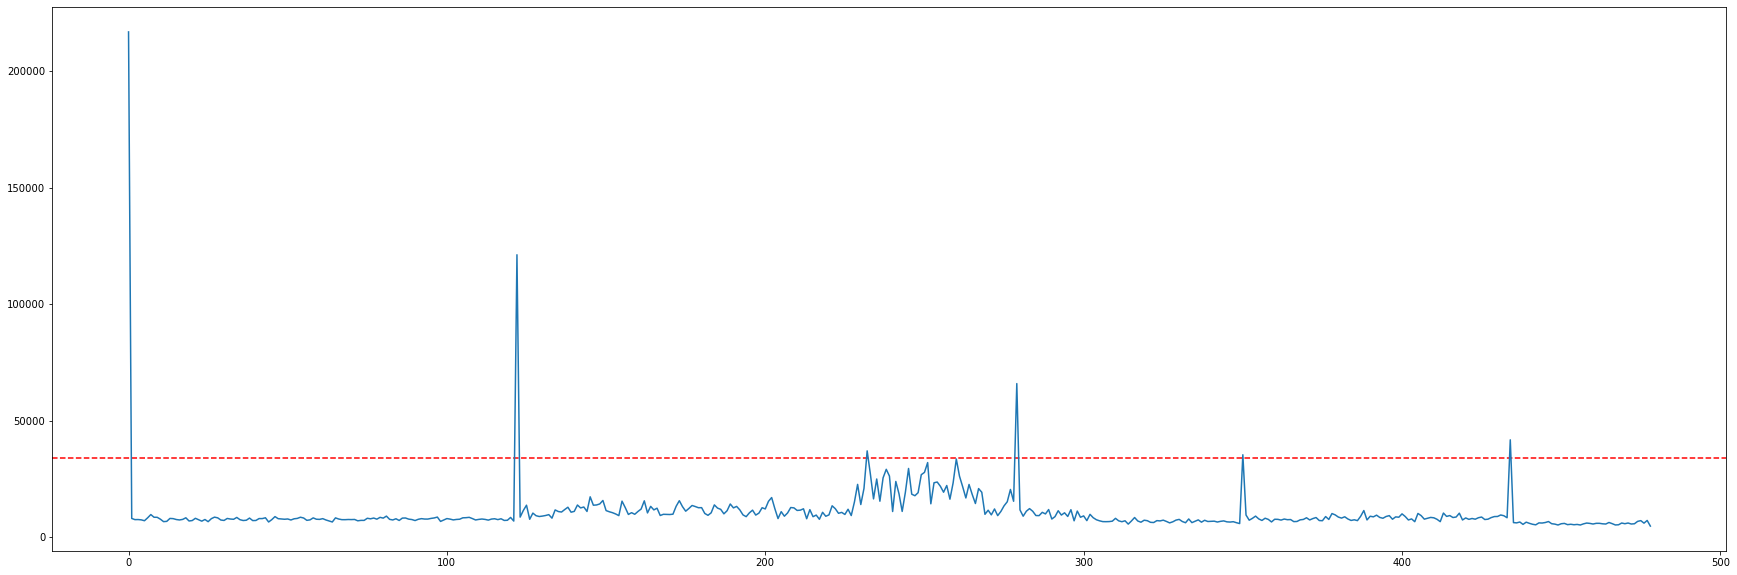

In [319]:
hist_diffs = np.abs(np.diff(histograms, axis = 0))
hist_agg = np.sum(hist_diffs, axis = 1)

fig, ax = plt.subplots(figsize = (30,10))
ax.axhline(y = 34000, color = 'r', linestyle = '--')
ax.plot(hist_agg)

In [313]:
mean = np.mean(hist_agg[1:])
sigma = np.std(hist_agg[1:])
mean + 3.5 * sigma

36713.93380930617

In [320]:
hist_selected_frames = ((np.argwhere(hist_agg >= mean + 3* sigma)).ravel())
hist_new_frames = np_video[hist_selected_frames]
print('Quantidade de frames original: ', len(diffs))
print('Quantidade de frames após SBD: ', len(hist_new_frames))

Quantidade de frames original:  479
Quantidade de frames após SBD:  7


In [310]:
hist_selected_frames

array([  0, 122, 279])

In [321]:
for frame in hist_new_frames:
    cv2.imshow('Frame', frame)

    
    # Press Q on keyboard to  exit
    if cv2.waitKey(1000) & 0xFF == ord('q'):
      break

cv2.destroyAllWindows()


In [305]:
hist_selected_frames

array([  0, 122, 232, 279, 350, 434])

In [274]:
reference = np.histogram(np_video[0], np.arange(256))

In [272]:
reference[1].shape

(255,)

<BarContainer object of 255 artists>

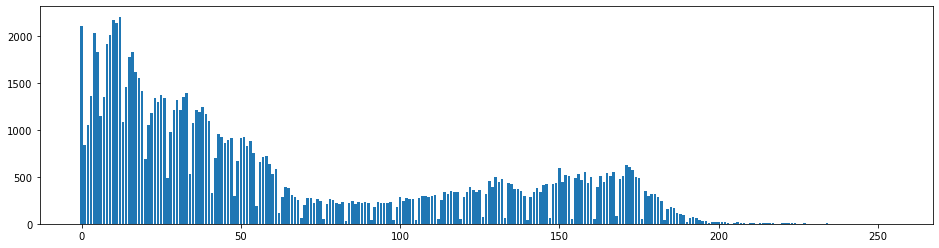

In [278]:
fig, ax = plt.subplots(figsize = (16,4))
ax.bar(reference[1][:-1], reference[0])